In [1]:
# 1.library import

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
# 2.Load Dataset
df = pd.read_csv("./tmQM_y.csv", sep = ';')
df.shape
df.columns.tolist()

['CSD_code',
 'Electronic_E',
 'Dispersion_E',
 'Dipole_M',
 'Metal_q',
 'HL_Gap',
 'HOMO_Energy',
 'LUMO_Energy',
 'Polarizability',
 'CSD_years',
 'SMILES']

In [3]:
# 3.Clean Dataset
df = df[df['SMILES'].notna()].copy()
df = df[df['SMILES'] != ''].copy()

In [4]:
# 4.SMILES Validaton
def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    except:
        return False

df['valid_smiles'] = df['SMILES'].apply(validate_smiles)
df = df[df['valid_smiles']].copy()
print(len(df))

[01:14:03] WARNING: not removing hydrogen atom without neighbors
[01:14:03] WARNING: not removing hydrogen atom without neighbors
[01:14:03] Explicit valence for atom # 11 P, 6, is greater than permitted
[01:14:03] Explicit valence for atom # 1 As, 5, is greater than permitted
[01:14:04] Explicit valence for atom # 14 P, 6, is greater than permitted
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:04] WARNING: not removing hydrogen atom without neighbors
[01:14:05] WARNING: not removing hydrogen atom without neighbors
[01:14:05] WARNING: not removing hydrogen atom without neighbors
[01:14:05] WARNING: not removing hydrogen atom without neighbor

100831


=== Gap Statistics ===
count    100831.000000
mean          0.108979
std           0.033320
min           0.002220
25%           0.088360
50%           0.109650
75%           0.129880
max           0.307420
Name: HL_Gap, dtype: float64


[01:14:24] WARNING: not removing hydrogen atom without neighbors
[01:14:24] WARNING: not removing hydrogen atom without neighbors
[01:14:24] WARNING: not removing hydrogen atom without neighbors
[01:14:24] WARNING: not removing hydrogen atom without neighbors
[01:14:24] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:25] WARNING: not removing hydrogen atom without neighbors
[01:14:26] WARNING: not removing hydrogen atom without neighbors
[01:14:27] WARNING: not removing hydrogen atom without neighbors
[01:14:27] WARNING: not removing hydrogen atom without neighbors
[01:14:28] WARNING: not removing hydrogen atom without neighbors
[01:14:28] WARNING: not r


=== Metal Distribution ===
Metal
Pd    10161
Ni    10030
Ru     9067
Pt     7853
Zn     7043
Fe     5045
Ir     4695
Rh     4278
Au     4099
Re     4033
Mo     3868
Cu     3528
Co     3450
W      3199
Ti     3131
Name: count, dtype: int64

=== Molecular Weight Statistics ===
count    100831.000000
mean        612.386705
std         190.102383
min          95.460000
25%         474.586000
50%         586.921000
75%         721.413500
max        1792.712000
Name: MolWt, dtype: float64

=== Average HOMO-LUMO Gap by Metal (Top 10) ===
         mean     std  count
Metal                       
Au     0.1315  0.0324   4099
Zn     0.1227  0.0414   7043
Pt     0.1151  0.0302   7853
Ir     0.1141  0.0246   4695
Rh     0.1137  0.0225   4278
Pd     0.1120  0.0252  10161
Ru     0.1067  0.0276   9067
Fe     0.0994  0.0347   5045
Re     0.0984  0.0322   4033
Ni     0.0823  0.0295  10030


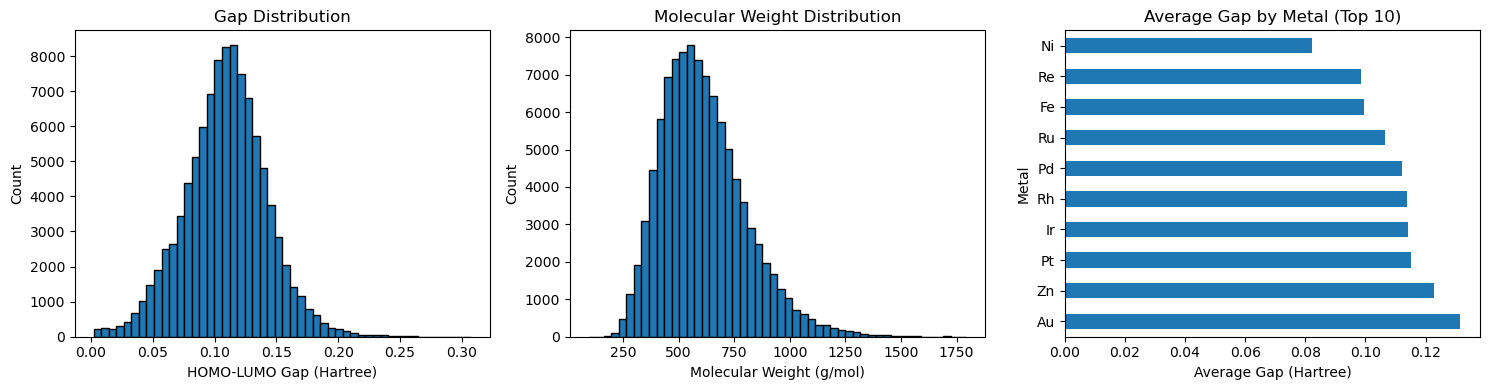


=== Correlation: Gap vs MolWt ===
Correlation coefficient: -0.1152


In [5]:
# 5.EDA

# Gap 통계
print("=== Gap Statistics ===")
print(df['HL_Gap'].describe())

# 금속 추출
def extract_metal(smiles):
    """SMILES에서 금속 원소 추출"""
    metals = ['Ti', 'Zr', 'Hf', 'Al', 'Ga', 'In', 
              'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ru', 'Rh', 'Pd',
              'Os', 'Ir', 'Pt', 'Mn', 'Cr', 'V', 'Sc', 'Y',
              'Nb', 'Mo', 'Tc', 'W', 'Re', 'Cd', 'Ag', 'Au']
    
    for metal in metals:
        if f'[{metal}' in smiles or f'{metal}]' in smiles:
            return metal
    return 'Unknown'

df['Metal'] = df['SMILES'].apply(extract_metal)

# 분자량 계산
def calculate_mw(smiles):
    """분자량 계산"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Descriptors.MolWt(mol)
        return None
    except:
        return None

df['MolWt'] = df['SMILES'].apply(calculate_mw)

# 금속 분포
print("\n=== Metal Distribution ===")
print(df['Metal'].value_counts().head(15))

# 분자량 통계
print("\n=== Molecular Weight Statistics ===")
print(df['MolWt'].describe())

# 금속별 평균 밴드갭 (상위 10개 금속만)
print("\n=== Average HOMO-LUMO Gap by Metal (Top 10) ===")
top_metals = df['Metal'].value_counts().head(10).index
metal_gap = df[df['Metal'].isin(top_metals)].groupby('Metal')['HL_Gap'].agg(['mean', 'std', 'count'])
metal_gap = metal_gap.sort_values('mean', ascending=False)
print(metal_gap.round(4))

# 간단한 시각화 (선택사항)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Gap 분포
axes[0].hist(df['HL_Gap'], bins=50, edgecolor='black')
axes[0].set_xlabel('HOMO-LUMO Gap (Hartree)')
axes[0].set_ylabel('Count')
axes[0].set_title('Gap Distribution')

# 분자량 분포
axes[1].hist(df['MolWt'].dropna(), bins=50, edgecolor='black')
axes[1].set_xlabel('Molecular Weight (g/mol)')
axes[1].set_ylabel('Count')
axes[1].set_title('Molecular Weight Distribution')

# 금속별 평균 Gap (상위 10개)
metal_gap['mean'].plot(kind='barh', ax=axes[2])
axes[2].set_xlabel('Average Gap (Hartree)')
axes[2].set_title('Average Gap by Metal (Top 10)')

plt.tight_layout()
plt.show()

# Gap vs 분자량 상관관계
print(f"\n=== Correlation: Gap vs MolWt ===")
correlation = df[['HL_Gap', 'MolWt']].corr().iloc[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")

In [6]:
# 6. 최종 데이터 저장
df_clean = df[['CSD_code', 'SMILES', 'HL_Gap', 'HOMO_Energy', 
               'LUMO_Energy', 'Metal', 'Dipole_M', 'Electronic_E']].copy() 

df_clean.columns = ['csd_code', 'smiles', 'gap', 'homo', 
                    'lumo', 'metal', 'dipole', 'energy']


df_clean.to_csv('tmQM_cleaned.csv', index = False)

In [7]:
# 7. RDKit 분자 기술자 자동 추출
def get_molecular_descriptors(max_autocorr=10):
    """RDKit에서 분자 기술자 자동 추출"""
    descriptor_list_all = []
    test_mol = Chem.MolFromSmiles('CCO')
    
    # 모든 유효한 기술자 수집
    for name in dir(Descriptors):
        if not name.startswith('_'):
            try:
                func = getattr(Descriptors, name)
                if callable(func):
                    result = func(test_mol)
                    if isinstance(result, (int, float)) and not np.isnan(result):
                        descriptor_list_all.append((name, func))
            except:
                pass
    
    print(f" 발견된 총 기술자: {len(descriptor_list_all)}")
    
    # AUTOCORR2D 기술자 정렬 및 제한
    autocorr_descriptors = [
        (name, func)
        for name, func in descriptor_list_all
        if name.startswith('AUTOCORR2D_')
    ]
    autocorr_descriptors.sort(key=lambda x: int(x[0].split('_')[-1]))
    limited_autocorr = autocorr_descriptors[:max_autocorr]
    
    # 다른 기술자들
    other_descriptors = [
        (name, func)
        for name, func in descriptor_list_all
        if not name.startswith('AUTOCORR2D_')
    ]
    
    # 최종 기술자 리스트
    descriptor_list = limited_autocorr + other_descriptors
    
    print(f"✅ 사용할 기술자: {len(descriptor_list)} (AUTOCORR2D 최대 {max_autocorr}개)")
    names = [name for name, _ in descriptor_list]
    print("\n주요 기술자:")
    print(", ".join(names[:20]) + "...")
    
    return descriptor_list

molecular_descriptors = get_molecular_descriptors(max_autocorr=10)
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
print(f"\nMorgan Fingerprint: 2048 bits")

 발견된 총 기술자: 409
✅ 사용할 기술자: 227 (AUTOCORR2D 최대 10개)

주요 기술자:
AUTOCORR2D_1, AUTOCORR2D_2, AUTOCORR2D_3, AUTOCORR2D_4, AUTOCORR2D_5, AUTOCORR2D_6, AUTOCORR2D_7, AUTOCORR2D_8, AUTOCORR2D_9, AUTOCORR2D_10, AvgIpc, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW, BCUT2D_MWHI, BCUT2D_MWLOW, BalabanJ...

Morgan Fingerprint: 2048 bits


In [8]:
# 8. SMILES → Features 변환
def smiles_to_enhanced_features(smiles, molecular_descriptors, morgan_gen):
    """
    SMILES를 Morgan fingerprint + RDKit 기술자로 변환
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Morgan fingerprint
    fp = morgan_gen.GetFingerprint(mol)
    fp_array = np.array(fp)
    
    # RDKit 기술자들
    rdkit_desc = []
    for name, func in molecular_descriptors:
        try:
            value = func(mol)
            if np.isinf(value) or abs(value) > 1e10:
                value = np.nan
            rdkit_desc.append(value)
        except:
            rdkit_desc.append(np.nan)
    
    # Morgan fingerprint + RDKit 기술자 결합
    return np.concatenate([fp_array, rdkit_desc])

print("Feature 변환 함수 정의 완료")

Feature 변환 함수 정의 완료


In [9]:
# 9. 모든 분자에 대해 feature 추출
df = df_clean
features = []
valid_indices = []

total = len(df)
for idx, smiles in enumerate(df['smiles']):
    feat = smiles_to_enhanced_features(smiles, molecular_descriptors, morgan_gen)
    if feat is not None:
        features.append(feat)
        valid_indices.append(idx)
    
    if (idx + 1) % 1000 == 0 or idx == total - 1:
        print(f"진행: {idx + 1}/{total}")

X = np.array(features)
y = df.iloc[valid_indices]['gap'].values

print(f"\n특성 행렬 크기: {X.shape}")
print(f"  - Morgan fingerprint: 2048 bits")
print(f"  - RDKit 기술자: {len(molecular_descriptors)} 개")
print(f"  - 총 특성 수: {X.shape[1]}")

[01:15:01] WARNING: not removing hydrogen atom without neighbors
[01:15:01] WARNING: not removing hydrogen atom without neighbors
[01:15:01] WARNING: not removing hydrogen atom without neighbors
[01:15:01] WARNING: not removing hydrogen atom without neighbors


진행: 1000/100831


[01:15:31] WARNING: not removing hydrogen atom without neighbors
[01:15:31] WARNING: not removing hydrogen atom without neighbors
[01:15:32] WARNING: not removing hydrogen atom without neighbors
[01:15:32] WARNING: not removing hydrogen atom without neighbors
[01:15:32] WARNING: not removing hydrogen atom without neighbors
[01:15:32] WARNING: not removing hydrogen atom without neighbors


진행: 2000/100831
진행: 3000/100831
진행: 4000/100831


[01:16:16] WARNING: not removing hydrogen atom without neighbors
[01:16:16] WARNING: not removing hydrogen atom without neighbors
[01:16:18] WARNING: not removing hydrogen atom without neighbors
[01:16:18] WARNING: not removing hydrogen atom without neighbors


진행: 5000/100831


[01:16:33] WARNING: not removing hydrogen atom without neighbors
[01:16:33] WARNING: not removing hydrogen atom without neighbors
[01:16:38] WARNING: not removing hydrogen atom without neighbors
[01:16:38] WARNING: not removing hydrogen atom without neighbors


진행: 6000/100831


[01:16:55] WARNING: not removing hydrogen atom without neighbors
[01:16:55] WARNING: not removing hydrogen atom without neighbors
[01:16:55] WARNING: not removing hydrogen atom without neighbors
[01:16:55] WARNING: not removing hydrogen atom without neighbors


진행: 7000/100831
진행: 8000/100831


[01:17:34] WARNING: not removing hydrogen atom without neighbors
[01:17:34] WARNING: not removing hydrogen atom without neighbors


진행: 9000/100831
진행: 10000/100831
진행: 11000/100831


[01:18:44] WARNING: not removing hydrogen atom without neighbors
[01:18:44] WARNING: not removing hydrogen atom without neighbors


진행: 12000/100831


[01:19:01] WARNING: not removing hydrogen atom without neighbors
[01:19:01] WARNING: not removing hydrogen atom without neighbors


진행: 13000/100831
진행: 14000/100831
진행: 15000/100831
진행: 16000/100831


[01:20:27] WARNING: not removing hydrogen atom without neighbors
[01:20:27] WARNING: not removing hydrogen atom without neighbors
[01:20:29] WARNING: not removing hydrogen atom without neighbors
[01:20:29] WARNING: not removing hydrogen atom without neighbors


진행: 17000/100831
진행: 18000/100831


[01:21:25] WARNING: not removing hydrogen atom without neighbors
[01:21:25] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors
[01:21:28] WARNING: not removing hydrogen atom without neighbors


진행: 19000/100831


[01:21:30] WARNING: not removing hydrogen atom without neighbors
[01:21:30] WARNING: not removing hydrogen atom without neighbors
[01:21:30] WARNING: not removing hydrogen atom without neighbors
[01:21:30] WARNING: not removing hydrogen atom without neighbors
[01:21:34] WARNING: not removing hydrogen atom without neighbors
[01:21:34] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:41] WARNING: not removing hydrogen atom without neighbors
[01:21:45] WARNING: not removing hydrogen atom without neighbors
[01:21:45] WARNING: not removing hydrogen atom without neighbors
[01:21:45] WARNING: not removing hydrogen atom without neighbors
[01:21:45] WARNING: not r

진행: 20000/100831
진행: 21000/100831


[01:22:47] WARNING: not removing hydrogen atom without neighbors
[01:22:47] WARNING: not removing hydrogen atom without neighbors


진행: 22000/100831


[01:23:18] WARNING: not removing hydrogen atom without neighbors
[01:23:18] WARNING: not removing hydrogen atom without neighbors
[01:23:24] WARNING: not removing hydrogen atom without neighbors
[01:23:24] WARNING: not removing hydrogen atom without neighbors


진행: 23000/100831


[01:23:50] WARNING: not removing hydrogen atom without neighbors
[01:23:50] WARNING: not removing hydrogen atom without neighbors


진행: 24000/100831
진행: 25000/100831


[01:24:28] WARNING: not removing hydrogen atom without neighbors
[01:24:28] WARNING: not removing hydrogen atom without neighbors


진행: 26000/100831


[01:24:55] WARNING: not removing hydrogen atom without neighbors
[01:24:55] WARNING: not removing hydrogen atom without neighbors


진행: 27000/100831
진행: 28000/100831


[01:25:29] WARNING: not removing hydrogen atom without neighbors
[01:25:29] WARNING: not removing hydrogen atom without neighbors


진행: 29000/100831
진행: 30000/100831


[01:26:22] WARNING: not removing hydrogen atom without neighbors
[01:26:22] WARNING: not removing hydrogen atom without neighbors
[01:26:25] WARNING: not removing hydrogen atom without neighbors
[01:26:25] WARNING: not removing hydrogen atom without neighbors


진행: 31000/100831


[01:26:29] WARNING: not removing hydrogen atom without neighbors
[01:26:29] WARNING: not removing hydrogen atom without neighbors
[01:26:35] WARNING: not removing hydrogen atom without neighbors
[01:26:35] WARNING: not removing hydrogen atom without neighbors
[01:26:45] WARNING: not removing hydrogen atom without neighbors
[01:26:45] WARNING: not removing hydrogen atom without neighbors


진행: 32000/100831


[01:26:56] WARNING: not removing hydrogen atom without neighbors
[01:26:56] WARNING: not removing hydrogen atom without neighbors


진행: 33000/100831


[01:27:25] WARNING: not removing hydrogen atom without neighbors
[01:27:25] WARNING: not removing hydrogen atom without neighbors


진행: 34000/100831


[01:27:38] WARNING: not removing hydrogen atom without neighbors
[01:27:38] WARNING: not removing hydrogen atom without neighbors


진행: 35000/100831
진행: 36000/100831
진행: 37000/100831


[01:28:29] WARNING: not removing hydrogen atom without neighbors
[01:28:29] WARNING: not removing hydrogen atom without neighbors
[01:28:31] WARNING: not removing hydrogen atom without neighbors
[01:28:31] WARNING: not removing hydrogen atom without neighbors


진행: 38000/100831
진행: 39000/100831


[01:29:20] WARNING: not removing hydrogen atom without neighbors
[01:29:20] WARNING: not removing hydrogen atom without neighbors


진행: 40000/100831


[01:29:47] WARNING: not removing hydrogen atom without neighbors
[01:29:47] WARNING: not removing hydrogen atom without neighbors


진행: 41000/100831
진행: 42000/100831


[01:30:32] WARNING: not removing hydrogen atom without neighbors
[01:30:32] WARNING: not removing hydrogen atom without neighbors
[01:30:35] WARNING: not removing hydrogen atom without neighbors
[01:30:35] WARNING: not removing hydrogen atom without neighbors


진행: 43000/100831
진행: 44000/100831


[01:31:26] WARNING: not removing hydrogen atom without neighbors
[01:31:26] WARNING: not removing hydrogen atom without neighbors
[01:31:31] WARNING: not removing hydrogen atom without neighbors
[01:31:31] WARNING: not removing hydrogen atom without neighbors


진행: 45000/100831


[01:31:36] WARNING: not removing hydrogen atom without neighbors
[01:31:36] WARNING: not removing hydrogen atom without neighbors
[01:31:43] WARNING: not removing hydrogen atom without neighbors
[01:31:43] WARNING: not removing hydrogen atom without neighbors
[01:31:49] WARNING: not removing hydrogen atom without neighbors
[01:31:49] WARNING: not removing hydrogen atom without neighbors


진행: 46000/100831


[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:19] WARNING: not removing hydrogen atom without neighbors
[01:32:24] WARNING: not removing hydrogen atom without neighbors
[01:32:24] WARNING: not removing hydrogen atom without neighbors


진행: 47000/100831
진행: 48000/100831
진행: 49000/100831


[01:33:22] WARNING: not removing hydrogen atom without neighbors
[01:33:22] WARNING: not removing hydrogen atom without neighbors
[01:33:33] WARNING: not removing hydrogen atom without neighbors
[01:33:33] WARNING: not removing hydrogen atom without neighbors


진행: 50000/100831


[01:34:07] WARNING: not removing hydrogen atom without neighbors
[01:34:07] WARNING: not removing hydrogen atom without neighbors


진행: 51000/100831


[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:23] WARNING: not removing hydrogen atom without neighbors
[01:34:25] WARNING: not removing hydrogen atom without neighbors
[01:34:25] WARNING: not removing hydrogen atom without neighbors


진행: 52000/100831


[01:34:43] WARNING: not removing hydrogen atom without neighbors
[01:34:43] WARNING: not removing hydrogen atom without neighbors


진행: 53000/100831


[01:35:06] WARNING: not removing hydrogen atom without neighbors
[01:35:06] WARNING: not removing hydrogen atom without neighbors


진행: 54000/100831
진행: 55000/100831


[01:35:53] WARNING: not removing hydrogen atom without neighbors
[01:35:53] WARNING: not removing hydrogen atom without neighbors
[01:36:00] WARNING: not removing hydrogen atom without neighbors
[01:36:00] WARNING: not removing hydrogen atom without neighbors
[01:36:00] WARNING: not removing hydrogen atom without neighbors
[01:36:00] WARNING: not removing hydrogen atom without neighbors
[01:36:13] WARNING: not removing hydrogen atom without neighbors
[01:36:13] WARNING: not removing hydrogen atom without neighbors
[01:36:13] WARNING: not removing hydrogen atom without neighbors
[01:36:13] WARNING: not removing hydrogen atom without neighbors


진행: 56000/100831


[01:36:28] WARNING: not removing hydrogen atom without neighbors
[01:36:28] WARNING: not removing hydrogen atom without neighbors


진행: 57000/100831


[01:37:01] WARNING: not removing hydrogen atom without neighbors
[01:37:02] WARNING: not removing hydrogen atom without neighbors


진행: 58000/100831


[01:37:05] WARNING: not removing hydrogen atom without neighbors
[01:37:05] WARNING: not removing hydrogen atom without neighbors
[01:37:06] WARNING: not removing hydrogen atom without neighbors
[01:37:06] WARNING: not removing hydrogen atom without neighbors
[01:37:10] WARNING: not removing hydrogen atom without neighbors
[01:37:10] WARNING: not removing hydrogen atom without neighbors


진행: 59000/100831
진행: 60000/100831


[01:37:58] WARNING: not removing hydrogen atom without neighbors
[01:37:58] WARNING: not removing hydrogen atom without neighbors
[01:38:08] WARNING: not removing hydrogen atom without neighbors
[01:38:08] WARNING: not removing hydrogen atom without neighbors
[01:38:13] WARNING: not removing hydrogen atom without neighbors
[01:38:13] WARNING: not removing hydrogen atom without neighbors


진행: 61000/100831


[01:38:16] WARNING: not removing hydrogen atom without neighbors
[01:38:16] WARNING: not removing hydrogen atom without neighbors
[01:38:16] WARNING: not removing hydrogen atom without neighbors
[01:38:16] WARNING: not removing hydrogen atom without neighbors
[01:38:27] WARNING: not removing hydrogen atom without neighbors
[01:38:27] WARNING: not removing hydrogen atom without neighbors
[01:38:29] WARNING: not removing hydrogen atom without neighbors
[01:38:29] WARNING: not removing hydrogen atom without neighbors


진행: 62000/100831


[01:38:53] WARNING: not removing hydrogen atom without neighbors
[01:38:53] WARNING: not removing hydrogen atom without neighbors


진행: 63000/100831


[01:39:21] WARNING: not removing hydrogen atom without neighbors
[01:39:21] WARNING: not removing hydrogen atom without neighbors


진행: 64000/100831


[01:39:28] WARNING: not removing hydrogen atom without neighbors
[01:39:28] WARNING: not removing hydrogen atom without neighbors


진행: 65000/100831
진행: 66000/100831
진행: 67000/100831
진행: 68000/100831


[01:40:59] WARNING: not removing hydrogen atom without neighbors
[01:40:59] WARNING: not removing hydrogen atom without neighbors


진행: 69000/100831


[01:41:14] WARNING: not removing hydrogen atom without neighbors
[01:41:14] WARNING: not removing hydrogen atom without neighbors
[01:41:14] WARNING: not removing hydrogen atom without neighbors
[01:41:14] WARNING: not removing hydrogen atom without neighbors


진행: 70000/100831
진행: 71000/100831
진행: 72000/100831
진행: 73000/100831
진행: 74000/100831
진행: 75000/100831


[01:43:26] WARNING: not removing hydrogen atom without neighbors
[01:43:26] WARNING: not removing hydrogen atom without neighbors
[01:43:26] WARNING: not removing hydrogen atom without neighbors
[01:43:26] WARNING: not removing hydrogen atom without neighbors


진행: 76000/100831
진행: 77000/100831


[01:44:17] WARNING: not removing hydrogen atom without neighbors
[01:44:17] WARNING: not removing hydrogen atom without neighbors


진행: 78000/100831
진행: 79000/100831
진행: 80000/100831
진행: 81000/100831
진행: 82000/100831


[01:45:58] WARNING: not removing hydrogen atom without neighbors
[01:45:58] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors
[01:46:05] WARNING: not removing hydrogen atom without neighbors


진행: 83000/100831
진행: 84000/100831
진행: 85000/100831
진행: 86000/100831
진행: 87000/100831
진행: 88000/100831


[01:48:06] WARNING: not removing hydrogen atom without neighbors
[01:48:06] WARNING: not removing hydrogen atom without neighbors
[01:48:29] WARNING: not removing hydrogen atom without neighbors
[01:48:29] WARNING: not removing hydrogen atom without neighbors


진행: 89000/100831


[01:48:36] WARNING: not removing hydrogen atom without neighbors
[01:48:36] WARNING: not removing hydrogen atom without neighbors
[01:48:39] WARNING: not removing hydrogen atom without neighbors
[01:48:39] WARNING: not removing hydrogen atom without neighbors
[01:48:53] WARNING: not removing hydrogen atom without neighbors
[01:48:53] WARNING: not removing hydrogen atom without neighbors


진행: 90000/100831
진행: 91000/100831


[01:49:21] WARNING: not removing hydrogen atom without neighbors
[01:49:21] WARNING: not removing hydrogen atom without neighbors
[01:49:26] WARNING: not removing hydrogen atom without neighbors
[01:49:26] WARNING: not removing hydrogen atom without neighbors


진행: 92000/100831
진행: 93000/100831
진행: 94000/100831
진행: 95000/100831
진행: 96000/100831
진행: 97000/100831
진행: 98000/100831


[01:52:17] WARNING: not removing hydrogen atom without neighbors
[01:52:17] WARNING: not removing hydrogen atom without neighbors


진행: 99000/100831


[01:52:40] WARNING: not removing hydrogen atom without neighbors
[01:52:40] WARNING: not removing hydrogen atom without neighbors


진행: 100000/100831
진행: 100831/100831

특성 행렬 크기: (100831, 2275)
  - Morgan fingerprint: 2048 bits
  - RDKit 기술자: 227 개
  - 총 특성 수: 2275


In [10]:
# 10. NaN 처리 - 각 열의 중앙값으로 대체
print("결측치 처리 중...")
nan_count = 0

for i in range(X.shape[1]):
    col = X[:, i]
    nan_mask = np.isnan(col)
    if np.any(nan_mask):
        nan_count += np.sum(nan_mask)
        median_val = np.nanmedian(col)
        if np.isnan(median_val):
            median_val = 0
        X[nan_mask, i] = median_val

print(f"총 {nan_count}개의 결측치 처리 완료")
print(f"현재 NaN 개수: {np.sum(np.isnan(X))}")

결측치 처리 중...
총 1229954개의 결측치 처리 완료
현재 NaN 개수: 0


In [11]:
# 11.모델 학습
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
model = lgb.LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    num_leaves=100,
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, n_estimators=1500, num_leaves=100,
              random_state=42, verbose=-1)

In [14]:
# 12.모델 평가
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(r2)

0.7531654298254302


In [13]:
# 13. ALD Precursor 예측
high_k_precursors = {
    'TDMAH': '[N-](C)C->[Hf+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'TEMAH': '[N-](C)CC->[Hf+4](<-[N-](C)CC)(<-[N-](C)CC)(<-[N-](C)CC)',
    'TDEAH': '[N-](CC)CC->[Hf+4](<-[N-](CC)CC)(<-[N-](CC)CC)(<-[N-](CC)CC)',
    'TDMAT': '[N-](C)C->[Ti+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'HfCl4': '[Cl-]->[Hf+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
    'TiCl4': '[Cl-]->[Ti+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
    'TTIP' : '[O-](C(C)C)->[Ti+4](<-[O-](C(C)C))(<-[O-](C(C)C))(<-[O-](C(C)C))',
    'TDMAZ':'[N-](C)C->[Zr+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'TMA' : 'C[Al](C)C',
    'ZrCl4 (Zr)':'[Cl-]->[Zr+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
}

print("-" * 60)
for name, smiles in high_k_precursors.items():
    feat = smiles_to_enhanced_features(smiles, molecular_descriptors, morgan_gen)
    if feat is not None:
        # NaN 처리
        for i in range(len(feat)):
            if np.isnan(feat[i]):
                feat[i] = 0
        
        gap_pred = model.predict([feat])[0]
        print(f"{name:15s}: {gap_pred:.4f} Hartree")
    else:
        print(f"{name:15s}: SMILES 파싱 실패")

print("-" * 60)

------------------------------------------------------------
TDMAH          : 0.1495 Hartree
TEMAH          : 0.1568 Hartree
TDEAH          : 0.1366 Hartree
TDMAT          : 0.1569 Hartree
HfCl4          : 0.1484 Hartree
TiCl4          : 0.1348 Hartree
TTIP           : 0.1487 Hartree
TDMAZ          : 0.1469 Hartree
TMA            : 0.1709 Hartree
ZrCl4 (Zr)     : 0.1490 Hartree
------------------------------------------------------------
